In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import UsefulFunctions as uf
from obspy import UTCDateTime

from obspy.signal.filter import envelope

client = Client("IRIS")



In [103]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

In [104]:
EV_NAME = 'Denali2002'
or_time = UTCDateTime('2002-11-03 22:12:41')
# Earthquake variables
# eq = uf.Earthquake(f'{uf.DATA_PATH}/AncScenarioGrids/Anc2018.xml')
eq = uf.Earthquake(f'grids/{EV_NAME}.xml')
eq_lat = eq.event['lat']
eq_lon = eq.event['lon']
eq_dep = eq.event['depth']
print(eq_lat, eq_lon, eq_dep)
# s_t = UTCDateTime(2022,1,1)
# e_t = UTCDateTime(2022,1,15)

# t_vec = np.arange(s_t,e_t,86400)
# print(or_time)

Start of Parsing for grids/Denali2002.xml
   ~~Detection stats~~
    Used a maximum azimuthal gap of 300 degrees and minimum station vector angle of 30 km
    Number of stations needed: 4
    Detection Time: 12.539993020324522
    Azimuthal Gap: 167.8069123015478
    Max Vector Angle: 165.96708043832322
    Maximum Epicentral Distance: 83.8749454008524
Finished parsing grid.xml for: M7.9, Central Alaska, at 2002-11-03T22:12:41 (ID:usp000bg0m)
63.517 -147.444 4.9


In [105]:
stations = ['PS07', 'PS08', 'PS09', 'PS10', 'PS11', 'PS12']
sampling_rate = 200  # Hz

data_dict = {}
for sta in stations:
    print(sta)
    data_dict[sta] = {}
    for comp in ['a','b','c']:
        filepath = f'psdata/alyeska.denali.{sta.lower()}{comp}.txt'
        with open(filepath, 'r') as file:
            text = file.readlines()
        data = text[139:]
        clock_time = text[67][-15:].strip('\n')  # line 67, last 14 characters needs +1 for \n char
        lat_dms = text[61][-23:].strip('\n')
        lat_dd = dms2dd(lat_dms[0:2], lat_dms[7:9], lat_dms[14:16], lat_dms[-1])
        lon_dms = text[62][-24:].strip('\n')
        lon_dd = dms2dd(lon_dms[0:3], lon_dms[8:10], lon_dms[15:17], lon_dms[-1])
        
            

        data_arr = np.array([])
        n = 10  # length of data values
        for i in range(len(data)):
            line = data[i].strip('\n')
            datalist = [line[i:i+n] for i in range(0, len(line), n)]  # split back up into
            for j in range(len(datalist)):
                datalist[j] = datalist[j].strip(' ')
            datafloats = np.array(datalist).astype(float)
            data_arr = np.hstack((data_arr, datafloats))
        data_dict[sta][comp] = data_arr
    
        print(comp)
        print(data_arr.size)
    start_time = UTCDateTime(f'2002-11-03 {clock_time}')
    record_length = data_arr.size/sampling_rate  # seconds
    end_time = start_time + record_length
    print(record_length)
    time_arr = np.arange(start_time, end_time, 1/sampling_rate)
    times_corrected = time_arr - or_time + 9*60*60
    data_dict[sta]['times'] = np.around(times_corrected.astype(float), 3)
    data_dict[sta]['lat'] = lat_dd
    data_dict[sta]['lon'] = lon_dd

print(time_arr)
print(clock_time)
print(start_time)
print(lat_degrees)

PS07
a
15270
b
15270
c
15270
76.35
PS08
a
15105
b
15105
c
15105
75.525
PS09
a
32895
b
32895
c
32895
164.475
PS10
a
18419
b
18419
c
18419
92.095
PS11
a
32958
b
32958
c
32958
164.79
PS12
a
20916
b
20916
c
20916
104.58
[UTCDateTime(2002, 11, 3, 13, 13, 28, 960000)
 UTCDateTime(2002, 11, 3, 13, 13, 28, 965000)
 UTCDateTime(2002, 11, 3, 13, 13, 28, 970000) ...
 UTCDateTime(2002, 11, 3, 13, 15, 13, 525000)
 UTCDateTime(2002, 11, 3, 13, 15, 13, 530000)
 UTCDateTime(2002, 11, 3, 13, 15, 13, 535000)]
13:13:28.96000
2002-11-03T13:13:28.960000Z
61 deg 28 min 33 sec N


In [106]:
print(data_dict['PS07']['times'].size)
print(data_dict['PS07']['times'][-1]-data_dict['PS07']['times'][0])
print(data_dict['PS07']['a'].size)
print(data_dict['PS07']['lon'])


15270
76.345
15270
-148.27861111111113


In [107]:
# EQ related information
for sta, data in data_dict.items():
    lat = data['lat']
    lon = data['lon']
    # Calculate epicentral and hypocentral distance, and first-arrival times
    epi_dist = uf.getDistance(eq_lat, eq_lon, lat, lon)
    hypo_dist = (epi_dist**2 + eq_dep**2)**.5

    # Save the info into the data dict
    data['epi_dist'] = epi_dist
    data['hypo_dist'] = hypo_dist


In [108]:
data_dict.items()

dict_items([('PS07', {'a': array([1.5362, 1.3686, 1.2847, ..., 2.6563, 2.6982, 2.6144]), 'b': array([-0.46163 , -0.33832 , -0.25611 , ...,  0.18    ,  0.18    ,
        0.097789]), 'c': array([-0.028786,  0.052016,  0.29442 , ..., -0.73384 , -0.57224 ,
       -0.45104 ]), 'times': array([ 44.55 ,  44.555,  44.56 , ..., 120.885, 120.89 , 120.895]), 'lat': 65.3111111111111, 'lon': -148.27861111111113, 'epi_dist': 203.47758572198813, 'hypo_dist': 203.53657629833768}), ('PS08', {'a': array([-0.028717, -0.028717, -0.028717, ..., -1.6403  , -1.4165  ,
       -1.2374  ]), 'b': array([ 0.0087343,  0.0087343,  0.0087343, ..., -1.2062   , -0.9967   ,
       -0.53589  ]), 'c': array([4.5568e-03, 4.5568e-03, 4.8583e-02, ..., 5.1555e+00, 4.9353e+00,
       4.5831e+00]), 'times': array([ 6.39 ,  6.395,  6.4  , ..., 81.9  , 81.905, 81.91 ]), 'lat': 64.54305555555555, 'lon': -146.81944444444443, 'epi_dist': 118.07416932495529, 'hypo_dist': 118.17579896822451}), ('PS09', {'a': array([-0.1211  ,  0.0104

Number of traces: 18


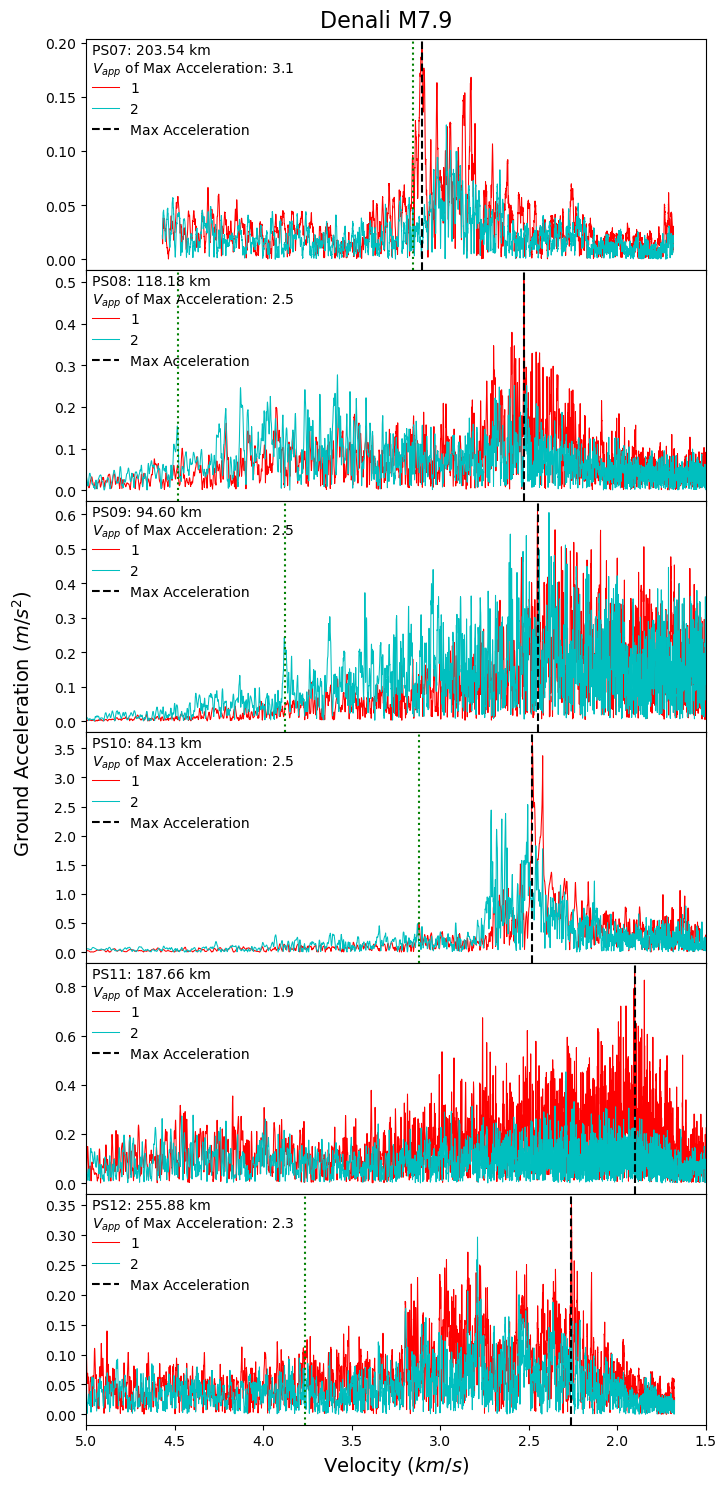

In [133]:
# st1.attach_response(inv)
# st1 = st1.remove_response(output='ACC')
n_tr = len(stations)*3
stringtotext = 'event, stationcode, hypodist, maxacc, vapp'
print('Number of traces:', n_tr)
alpha = 1
lw = 0.75
fs=14
vapp_list = []

fig, ax = plt.subplots(nrows=n_tr // 3, sharex=True, figsize=(8,n_tr))
fig.subplots_adjust(hspace=0)
i = 0
for name, data in data_dict.items():
    distance = data['hypo_dist']
    
    tr_1 = data['a'] /100
    tr_2 = data['b'] /100
    tr_z = data['c'] /100
    
    env_1 = envelope(tr_1)
    env_2 = envelope(tr_2)
    env_z = envelope(tr_z)
    
    times = data['times']
    v_app = distance/times

    h_max_acc = 'nope'
    h_max_ind = 'nope'
    h_max_vapp = 'nope'
    if np.max(env_1) >= np.max(env_2):
        h_max_ind = np.argmax(env_1)
        h_max_acc = np.max(env_1)
        h_max_vapp = v_app[h_max_ind]
    else:
        h_max_ind = np.argmax(env_2)
        h_max_acc = np.max(env_2)
        h_max_vapp = v_app[h_max_ind]
    
    ax[i].plot(v_app, env_1, c='r', label='1', lw=lw, alpha=alpha)
    ax[i].plot(v_app, env_2, c='c', label='2', lw=lw, alpha=alpha)
    # ax[i].plot(v_app, tr_z, c='k', label='z', lw=lw, alpha=alpha)    
    ax[i].axvline(h_max_vapp, ls='--', lw=2*lw, c='k', label='Max Acceleration')
    # *line to add green line when the station was triggered to start recording, converted to apparent vel
    ax[i].axvline(distance/(times[0]+20), ls=':', c='green')
    ax[i].text(.01, .98, '%s: %.2f km' % (name, distance), ha='left', va='top', transform=ax[i].transAxes)
    ax[i].text(.01, .91, r'$V_{app}$ of Max Acceleration: %.1f' % (np.round(h_max_vapp, 1)), ha='left', va='top', transform=ax[i].transAxes)
    ax[i].legend(loc=(0.0, .55), frameon=False, fancybox=False)
    # ax[i].set_title('%s: %.2f km' % (code, distance))
    vapp_list.append(h_max_vapp)
    stringtotext += '\n%s, %s, %.2f, %.2f, %.2f' % (EV_NAME, name, distance, h_max_acc, h_max_vapp)
    
    i += 1
plt.xlim(5, 1.5)
plt.xlabel(r'Velocity $(km/s)$', fontsize=fs)
fig.text(0.03, 0.5, r'Ground Acceleration $(m/s^2)$', va='center', rotation='vertical', fontsize=fs)
fig.text(0.5, 0.89, f'Denali M7.9', ha='center', va='center', fontsize=fs+2)
plt.savefig(f'Plots/{EV_NAME}.pdf')
plt.show()


In [135]:
print(vapp_list)
print(stringtotext)
with open(f'Vapps/{EV_NAME}_vapps.txt', 'w') as file:
    file.write(stringtotext)

[3.1034013310717037, 2.528094961348262, 2.4511619300235266, 2.4802235908450965, 1.902521059864759, 2.259591042353454]
event, stationcode, hypodist, maxacc, vapp
Denali2002, PS07, 203.54, 0.19, 3.10
Denali2002, PS08, 118.18, 0.50, 2.53
Denali2002, PS09, 94.60, 0.61, 2.45
Denali2002, PS10, 84.13, 3.60, 2.48
Denali2002, PS11, 187.66, 0.85, 1.90
Denali2002, PS12, 255.88, 0.35, 2.26


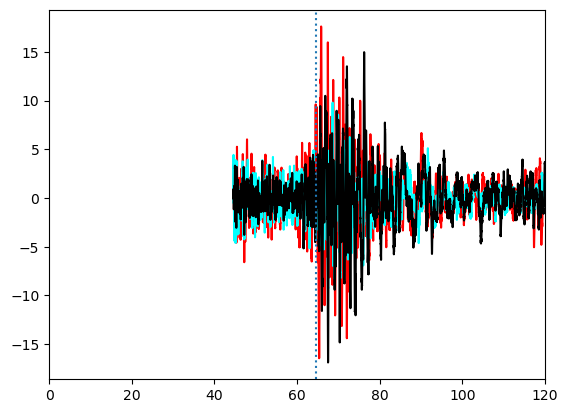

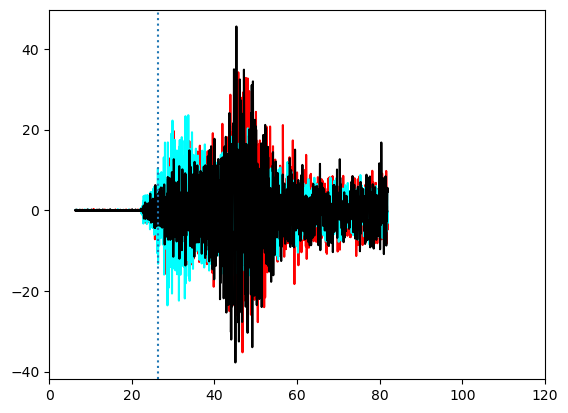

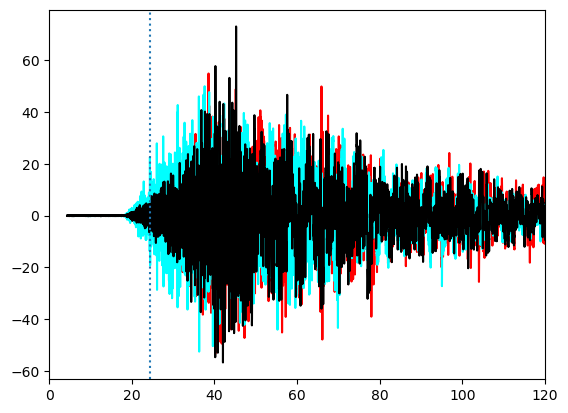

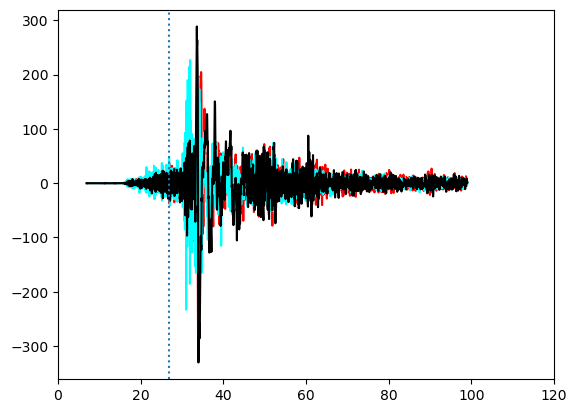

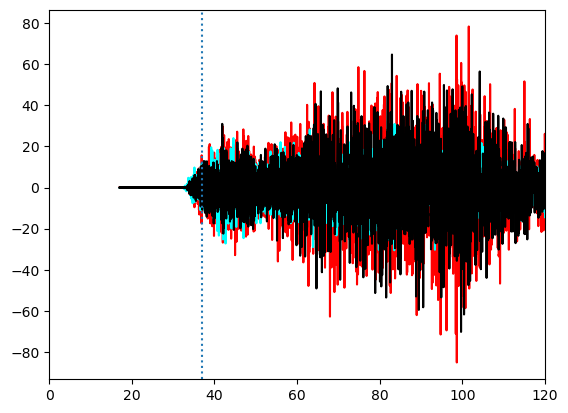

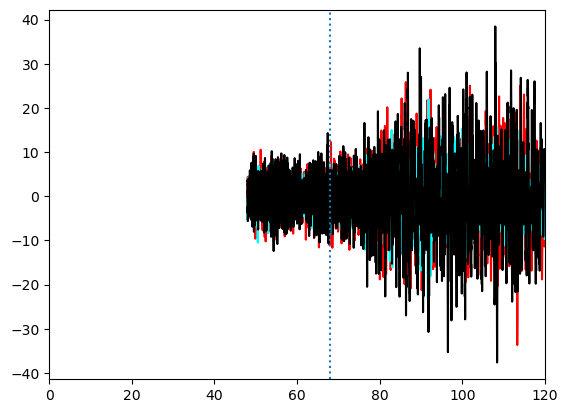

In [136]:
for name, data in data_dict.items():
    plt.figure()
    t = data['times']
    tr1 = data['a']
    tr2 = data['b']
    trz = data['c']
    plt.plot(t, tr1, c='r')
    plt.plot(t, tr2, c='cyan')
    plt.plot(t, trz, c='k')
    plt.axvline(t[0]+20, ls=':')
    plt.xlim(0,120)
    plt.title(f'name, dist:{}')

In [118]:
st[0].stats.network

'NP'

In [119]:
len(st)

15

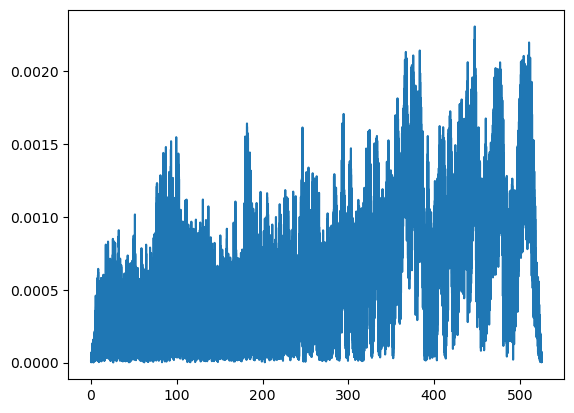

In [21]:
plt.figure()
plt.plot(st1[0].times(), envelope(st1[0].data))

In [121]:
st

15 Trace(s) in Stream:
NP.ABBK.01.HNE | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.ABBK.01.HNN | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.ABBK.01.HNZ | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AJKS.01.HNE | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AJKS.01.HNN | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AJKS.01.HNZ | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AMJG.01.HNE | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AMJG.01.HNN | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AMJG.01.HNZ | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.ARTY.01.HNE | 2013-01-05T08:00:00.000000Z - 201

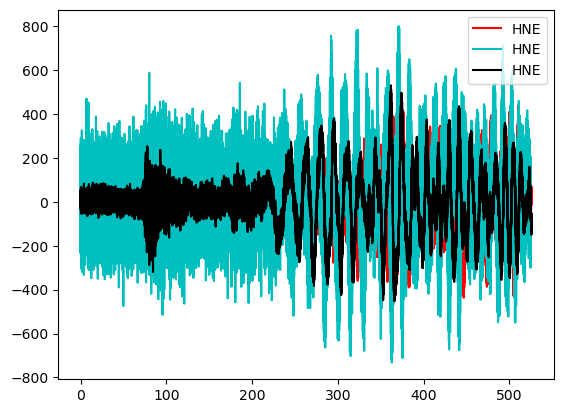

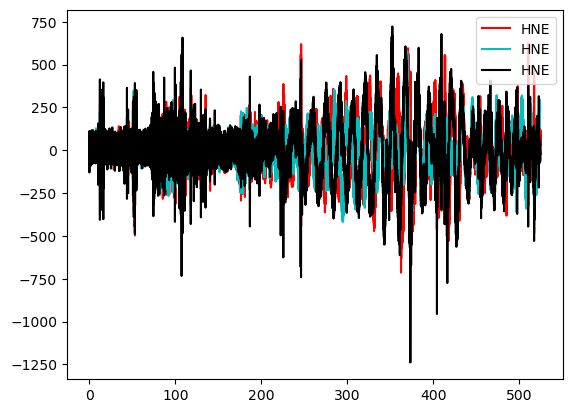

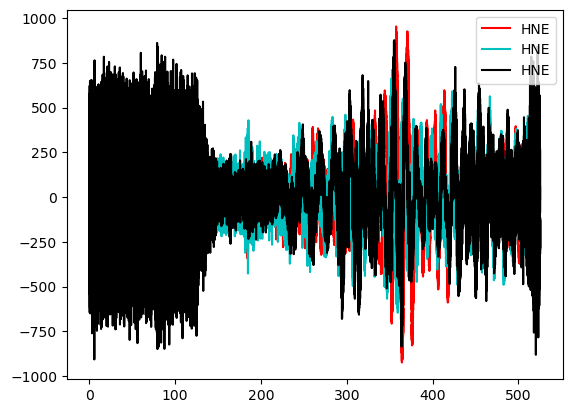

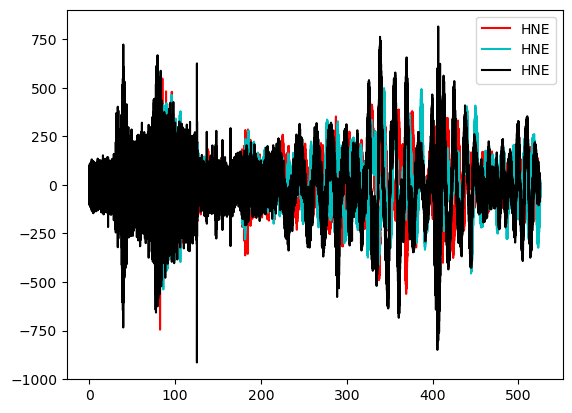

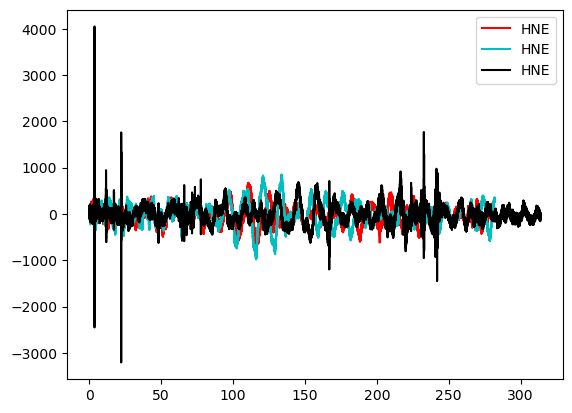

In [22]:
stt = st.copy()
stt.trim(starttime=starttime, endtime=endtime)

for i in range(len(stt)//3):
    plt.figure()
    # st[i].plot()
    code = stt[i*3].stats.station
    net = stt[i*3].stats.network
    # chan = st1[i].stats.channel
    distance = station_data[code]['hypo_dist']
    plt.plot(stt[i*3].times(), stt[i*3].data, c='r', label=stt[i*3].stats.channel)
    plt.plot(stt[i*3+1].times(), stt[i*3+1].data, c='c', label=stt[i*3].stats.channel)
    plt.plot(stt[i*3+2].times(), stt[i*3+2].data, c='k', label=stt[i*3].stats.channel)

    # plt.text(.01, .99, '%s.%s.%s: %.2f km' % (net, code, chan, distance), ha='left', va='top', transform=plt.transAxes)
    plt.legend(loc='upper right')

In [123]:
st[0*3+1].times())

SyntaxError: unmatched ')' (265354340.py, line 1)

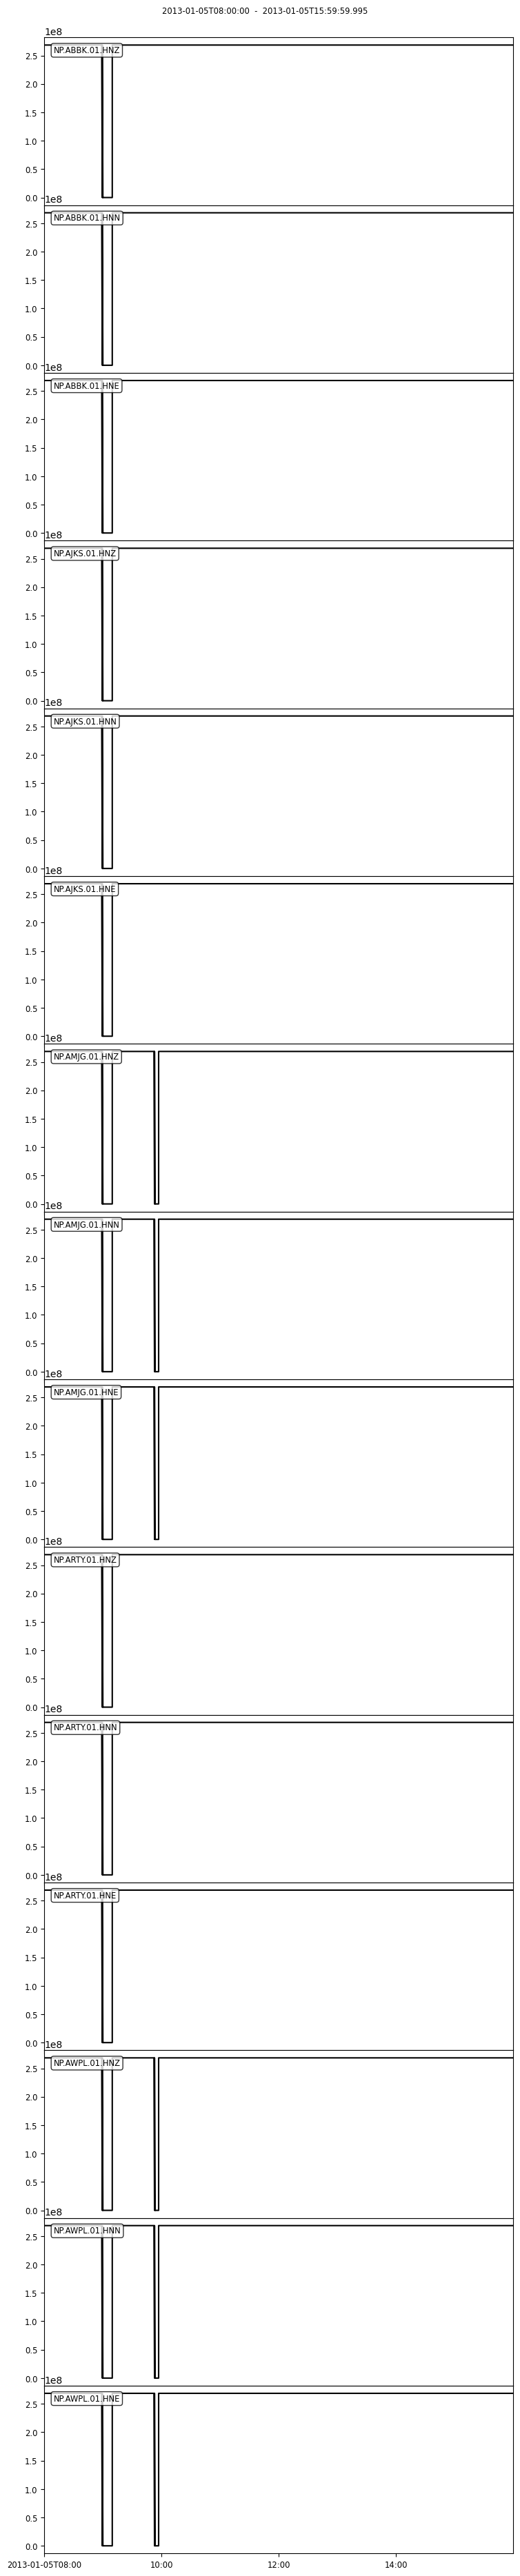

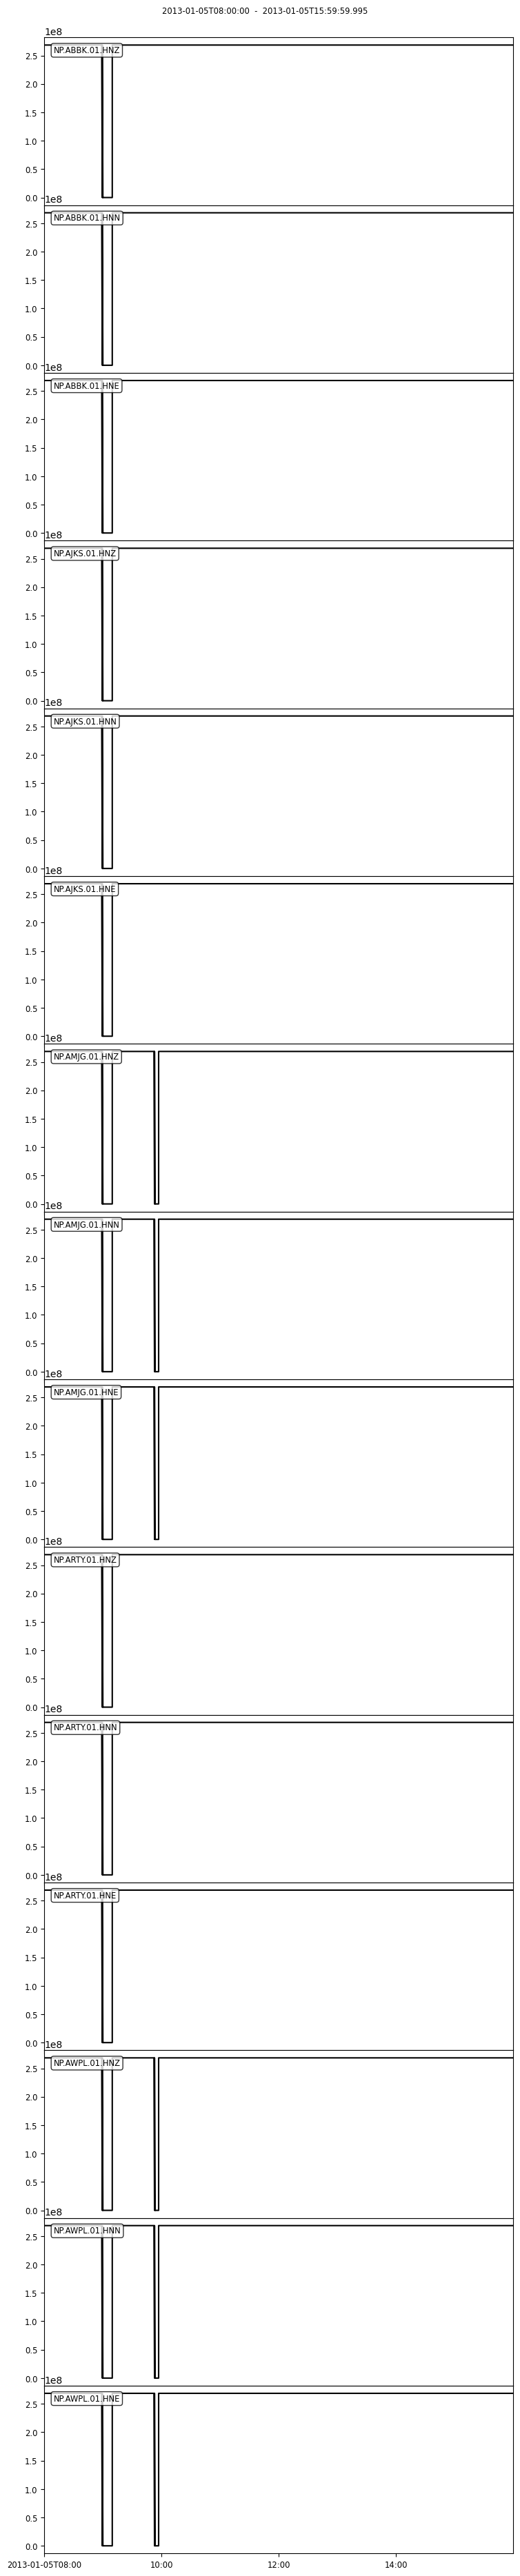

In [124]:
st.plot()